## taxonomy training

In [1]:
# Imports
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool, cv
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import collections
import pickle
from sklearn.metrics import classification_report
from catboost.utils import get_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

### Load train and test file

In [2]:
%%time
train_pool = Pool("../data/taxonomy_dataset_train_subset_100000.tsv", 
               column_description="../data/columns_description.cd")
val_pool = Pool("../data/taxonomy_dataset_validation_subset_removed_low_freq_100000.tsv", 
               column_description="../data/columns_description.cd")
test_pool = Pool("../data/taxonomy_dataset_test_subset_removed_low_freq_100000.tsv", 
               column_description="../data/columns_description.cd")

CPU times: user 8min 46s, sys: 1min 15s, total: 10min 1s
Wall time: 5min 55s


### Data shape

In [3]:
train_pool.shape

(70012, 68509)

In [4]:
val_pool.shape

(19935, 68509)

In [5]:
test_pool.shape

(10051, 68509)

In [6]:
train_labels = train_pool.get_label()
label_count = collections.Counter(train_labels).most_common()
print("Number of classes:", len(label_count))
for label, count in label_count:
    print(count, '\t', label)

Number of classes: 156
9825 	 root:Host-associated:Human:Digestive system:Large intestine:Fecal
8993 	 root:Mixed
7146 	 root:Host-associated:Human:Digestive system:Oral
4148 	 root:Host-associated:Mammals:Digestive system
3187 	 root:Host-associated:Human:Reproductive system:Vagina
3035 	 root:Environmental:Aquatic:Marine
2967 	 root:Host-associated:Human:Skin
2518 	 root:Environmental:Terrestrial:Soil
1771 	 root:Host-associated:Plants:Rhizosphere
1559 	 root:Environmental:Aquatic:Freshwater:Lake
1459 	 root:Host-associated:Human:Digestive system:Oral:Saliva
1014 	 root:Host-associated:Mammals:Digestive system:Stomach:Rumen
997 	 root:Host-associated:Human:Respiratory system:Nasopharyngeal
970 	 root:Host-associated:Plants
943 	 root:Host-associated:Mammals:Digestive system:Large intestine:Fecal
925 	 root:Environmental:Aquatic:Marine:Sediment
910 	 root:Host-associated:Human
852 	 root:Environmental:Aquatic:Marine:Oceanic
831 	 root:Environmental:Aquatic
771 	 root:Host-associated:H

### Load trained model 

In [7]:
# Init the model
model = CatBoostClassifier(
            custom_loss=['Accuracy'],# this line needs to be commented out if using pretrained model
            learning_rate=0.01,
            random_seed=42,
            iterations=3000,
            auto_class_weights = 'Balanced',
            task_type="GPU"
            )
trained_model = 'taxonomy_model_subset_100000_lr-0.01_itr-3000.json'
# if os.path.exists(trained_model):
#     model.load_model(trained_model, format='json')

### Model training

In [8]:
# Train
model.fit(
    train_pool,
    eval_set=val_pool,
    logging_level='Verbose',
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 4.9933620	test: 4.9790940	best: 4.9790940 (0)	total: 428ms	remaining: 21m 24s
1:	learn: 4.9520072	test: 4.9391315	best: 4.9391315 (1)	total: 780ms	remaining: 19m 29s
2:	learn: 4.9049139	test: 4.8663461	best: 4.8663461 (2)	total: 1.11s	remaining: 18m 32s
3:	learn: 4.8720066	test: 4.8402669	best: 4.8402669 (3)	total: 1.45s	remaining: 18m 7s
4:	learn: 4.8368089	test: 4.7914398	best: 4.7914398 (4)	total: 1.79s	remaining: 17m 52s
5:	learn: 4.8176766	test: 4.7482717	best: 4.7482717 (5)	total: 2.14s	remaining: 17m 46s
6:	learn: 4.7953132	test: 4.7377003	best: 4.7377003 (6)	total: 2.49s	remaining: 17m 46s
7:	learn: 4.7555640	test: 4.6928685	best: 4.6928685 (7)	total: 2.83s	remaining: 17m 39s
8:	learn: 4.7382997	test: 4.6788823	best: 4.6788823 (8)	total: 3.17s	remaining: 17m 34s
9:	learn: 4.7222046	test: 4.6659035	best: 4.6659035 (9)	total: 3.51s	remaining: 17m 29s
10:	learn: 4.6811884	test: 4.6243198	best: 4.6243198 (10)	total: 3.85s	remaining: 17m 25s
11:	learn: 4.6545201	test: 4.59

### Save model

In [9]:
# save model
model.save_model(trained_model,
           format="json",
           export_parameters=None,
           pool=train_pool)

### Prediction

In [10]:
model.score(test_pool)

0.9821908267834046

In [11]:
model.get_best_score()

{'learn': {'Accuracy:use_weights=true': 0.9939608182626252,
  'Accuracy:use_weights=false': 0.9831171799120151,
  'MultiClass': 0.12230077029098976},
 'validation': {'Accuracy:use_weights=true': 0.9889555812990866,
  'Accuracy:use_weights=false': 0.981239026837221,
  'MultiClass': 0.13314133984490242}}

### Analysis

In [12]:
X_test = test_pool.get_features()
y_test = test_pool.get_label()
with open('../data/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)
predictions = model.predict(X_test)


### Precision and recall

In [13]:
precision_recall_fscore_support(y_test, predictions, average=None)

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.


(array([1.        , 1.        , 0.61111111, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.        , 1.        , 0.75      ,
        1.        , 0.5       , 1.        , 0.95652174, 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.88888889, 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.98642534,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.        , 0.99775785, 0.70588235,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.5       , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.97345133, 1.        , 1.        , 1.        ,
        0.21568627, 0.93333333, 1.        , 0.92241379, 1.        ,
        1.        , 1.        , 1.        , 0.15686275, 1.        ,
        0.99700599, 0.97560976, 1.        , 1.  

In [14]:
precision_recall_fscore_support(y_test, predictions, average='micro')

(0.9821908267834046, 0.9821908267834046, 0.9821908267834046, None)

In [15]:
precision_recall_fscore_support(y_test, predictions, average='weighted')

(0.99081490964084, 0.9821908267834046, 0.9855240634190477, None)

In [16]:
precision_recall_fscore_support(y_test, predictions, average=None, labels=model.classes_)

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.


(array([1.        , 1.        , 0.61111111, 1.        , 1.        ,
        1.        , 1.        , 0.        , 1.        , 0.        ,
        1.        , 1.        , 0.        , 1.        , 1.        ,
        0.        , 0.        , 1.        , 0.75      , 1.        ,
        0.5       , 1.        , 0.95652174, 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.88888889, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.        , 1.        , 0.        ,
        0.98642534, 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.        , 1.        , 0.        ,
        0.99775785, 0.70588235, 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.5       , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.        , 0.97345133,
        1.        , 1.        , 1.        , 0.21568627, 0.93333333,
        1.        , 0.92241379, 1.        , 1.  

### Confusion matrix

In [17]:
confusion_matrix_test = get_confusion_matrix(model, test_pool)
print(confusion_matrix_test.shape)
print(len(model.classes_))
confusion_matrix_test_pd = pd.DataFrame(data=np.log(confusion_matrix_test+0.001), columns=model.classes_, index=model.classes_)

(156, 156)
156


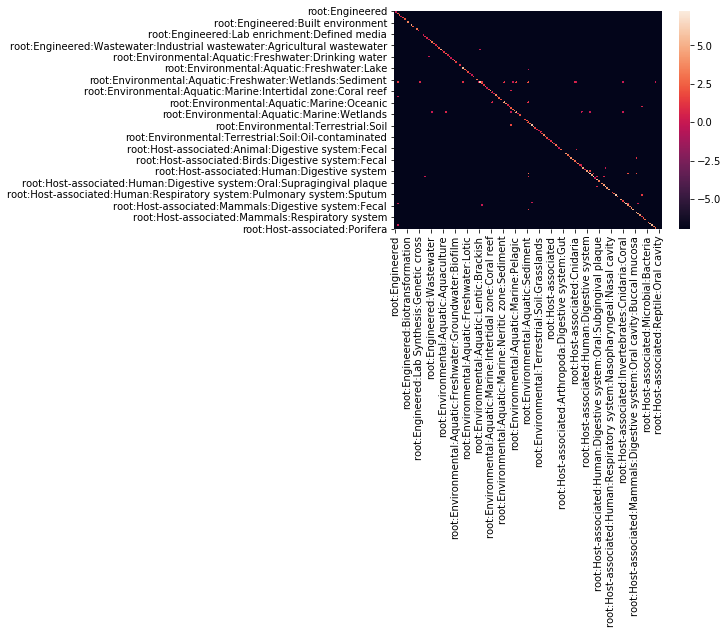

In [18]:
ax = sns.heatmap(confusion_matrix_test_pd)

### Feature importance

In [19]:
model_feature_importance = pd.Series(data=model.feature_importances_, index=model.feature_names_)
model_feature_importance

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
68504    0.0
68505    0.0
68506    0.0
68507    0.0
68508    0.0
Length: 68509, dtype: float64

In [ ]:
sorted_feature_importance = model_feature_importance[model_feature_importance.argsort()]
print(sorted_feature_importance)
plt.figure(figsize=(20,10))
plt.barh(sorted_feature_importance.values,
        sorted_feature_importance.index,
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

0        0.000000
45208    0.000000
45209    0.000000
45210    0.000000
45211    0.000000
           ...   
24432    2.311791
54908    2.462223
59285    2.639684
10850    4.032792
33655    6.368047
Length: 68509, dtype: float64


Text(0.5, 0, 'CatBoost Feature Importance')

### Shap values

In [ ]:
%%time
explainer_model = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer_model.shap_values(X_test)

In [ ]:
%%time
shap.summary_plot(shap_values, X_test, feature_names = feature_names, max_display=50, class_names=model.classes_,show=False)
f = plt.gcf()
plt.savefig('shap_summary_first_50.png',bbox_inches='tight')